### Starting Linear regression on house price prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from scipy.stats import uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline



Common setup

In [3]:
np.random.seed(42)

setting shuffle split

In [4]:
cross_validation_shuffle = ShuffleSplit(n_splits=10, test_size= 0.2, random_state= 42)

### Loading and spliting of data

In [5]:
features, labels = fetch_california_housing(return_X_y= True, as_frame= True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state= 42)

train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state= 42)

## Linear Regression with normal equation

In [6]:
def printTestResult(result, model:str):
  train_error, test_error = -1 * result['train_score'],  -1 * result['test_score']
  print(f'Mean absolute error of {model} model on the train set:\n',
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

  print(f'Mean absolute error of linear {model} on the test set:\n',
      f'{test_error.mean():.3f} +/- {test_error.std():.3f}')

In [7]:
lin_reg_pipeline = Pipeline([
  ('features_scaling', StandardScaler()),
  ('lin_reg', LinearRegression())
])

lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv= cross_validation_shuffle,
                                    scoring= 'neg_mean_absolute_error',
                                    return_train_score= True,
                                    return_estimator= True)

printTestResult(lin_reg_cv_results, 'Linear Regression')



Mean absolute error of Linear Regression model on the train set:
 0.530 +/- 0.002
Mean absolute error of linear Linear Regression on the test set:
 0.527 +/- 0.008


## Linear regression with SGD


In [8]:
sgd_reg_pipeline = Pipeline([
  ('features_scaling', StandardScaler()),
  ('sgd_reg', SGDRegressor(
    max_iter= int(np.ceil(
      1e6/com_train_features.shape[0])),
      early_stopping= True,
      eta0= 1e-4,
      learning_rate= 'constant',
      tol= 1e-5,
      validation_fraction= 0.1,
      n_iter_no_change= 5,
      average= 10,
      random_state= 42
  ))
])

sgd_reg_cv_result = cross_validate(sgd_reg_pipeline,
                                   com_train_features,
                                   com_train_labels,
                                   cv= cross_validation_shuffle,
                                   scoring= 'neg_mean_absolute_error',
                                   return_train_score= True,
                                   return_estimator= True)
printTestResult(sgd_reg_cv_result, "SGD Regression")

Mean absolute error of SGD Regression model on the train set:
 0.534 +/- 0.013
Mean absolute error of linear SGD Regression on the test set:
 0.530 +/- 0.010


## Polynomial Regression model with Degree 2

In [9]:
poly_reg_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2)),
  ('feature_scaling', StandardScaler()),
  ('lin_reg', LinearRegression())
])

poly_reg_cv_result = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv = cross_validation_shuffle,
                                    scoring= 'neg_mean_absolute_error', 
                                    return_train_score= True,
                                    return_estimator= True)

printTestResult(poly_reg_cv_result, "Polynomial Regression")

Mean absolute error of Polynomial Regression model on the train set:
 0.461 +/- 0.003
Mean absolute error of linear Polynomial Regression on the test set:
 0.485 +/- 0.030


### for only interaction features
interaction features means exclude all higher order features

In [10]:
poly_reg_interact_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2, interaction_only= True)),
  ('scaler', StandardScaler()),
  ('lin_reg', LinearRegression())
])

poly_interactive_result = cross_validate(poly_reg_interact_pipeline,
                                         com_train_features,
                                         com_train_labels,
                                         cv= cross_validation_shuffle,
                                         scoring='neg_mean_absolute_error',
                                         return_train_score= True,
                                         return_estimator= True)

printTestResult(poly_interactive_result, 'Interactive Polynomial result')

Mean absolute error of Interactive Polynomial result model on the train set:
 0.478 +/- 0.003
Mean absolute error of linear Interactive Polynomial result on the test set:
 0.497 +/- 0.024


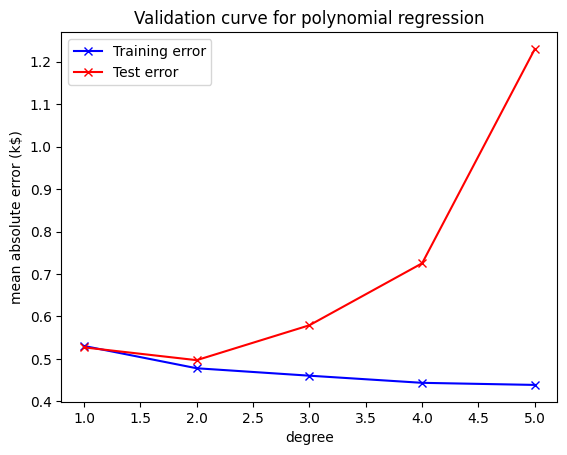

In [11]:
degree = [x for x in range(1, 6)]

train_scores, test_scores =  validation_curve(
  poly_reg_interact_pipeline, com_train_features, com_train_labels, param_name= 'poly__degree',
  param_range= degree, cv = cross_validation_shuffle, scoring='neg_mean_absolute_error', n_jobs=2
)

train_errors, test_errors = -train_scores, -test_scores

plt.plot(degree, train_errors.mean(axis= 1), 'b-x', label='Training error')
plt.plot(degree, test_errors.mean(axis= 1), 'r-x', label='Test error')
plt.legend()

plt.xlabel('degree')
plt.ylabel('mean absolute error (k$)')
plots = plt.title('Validation curve for polynomial regression')


/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


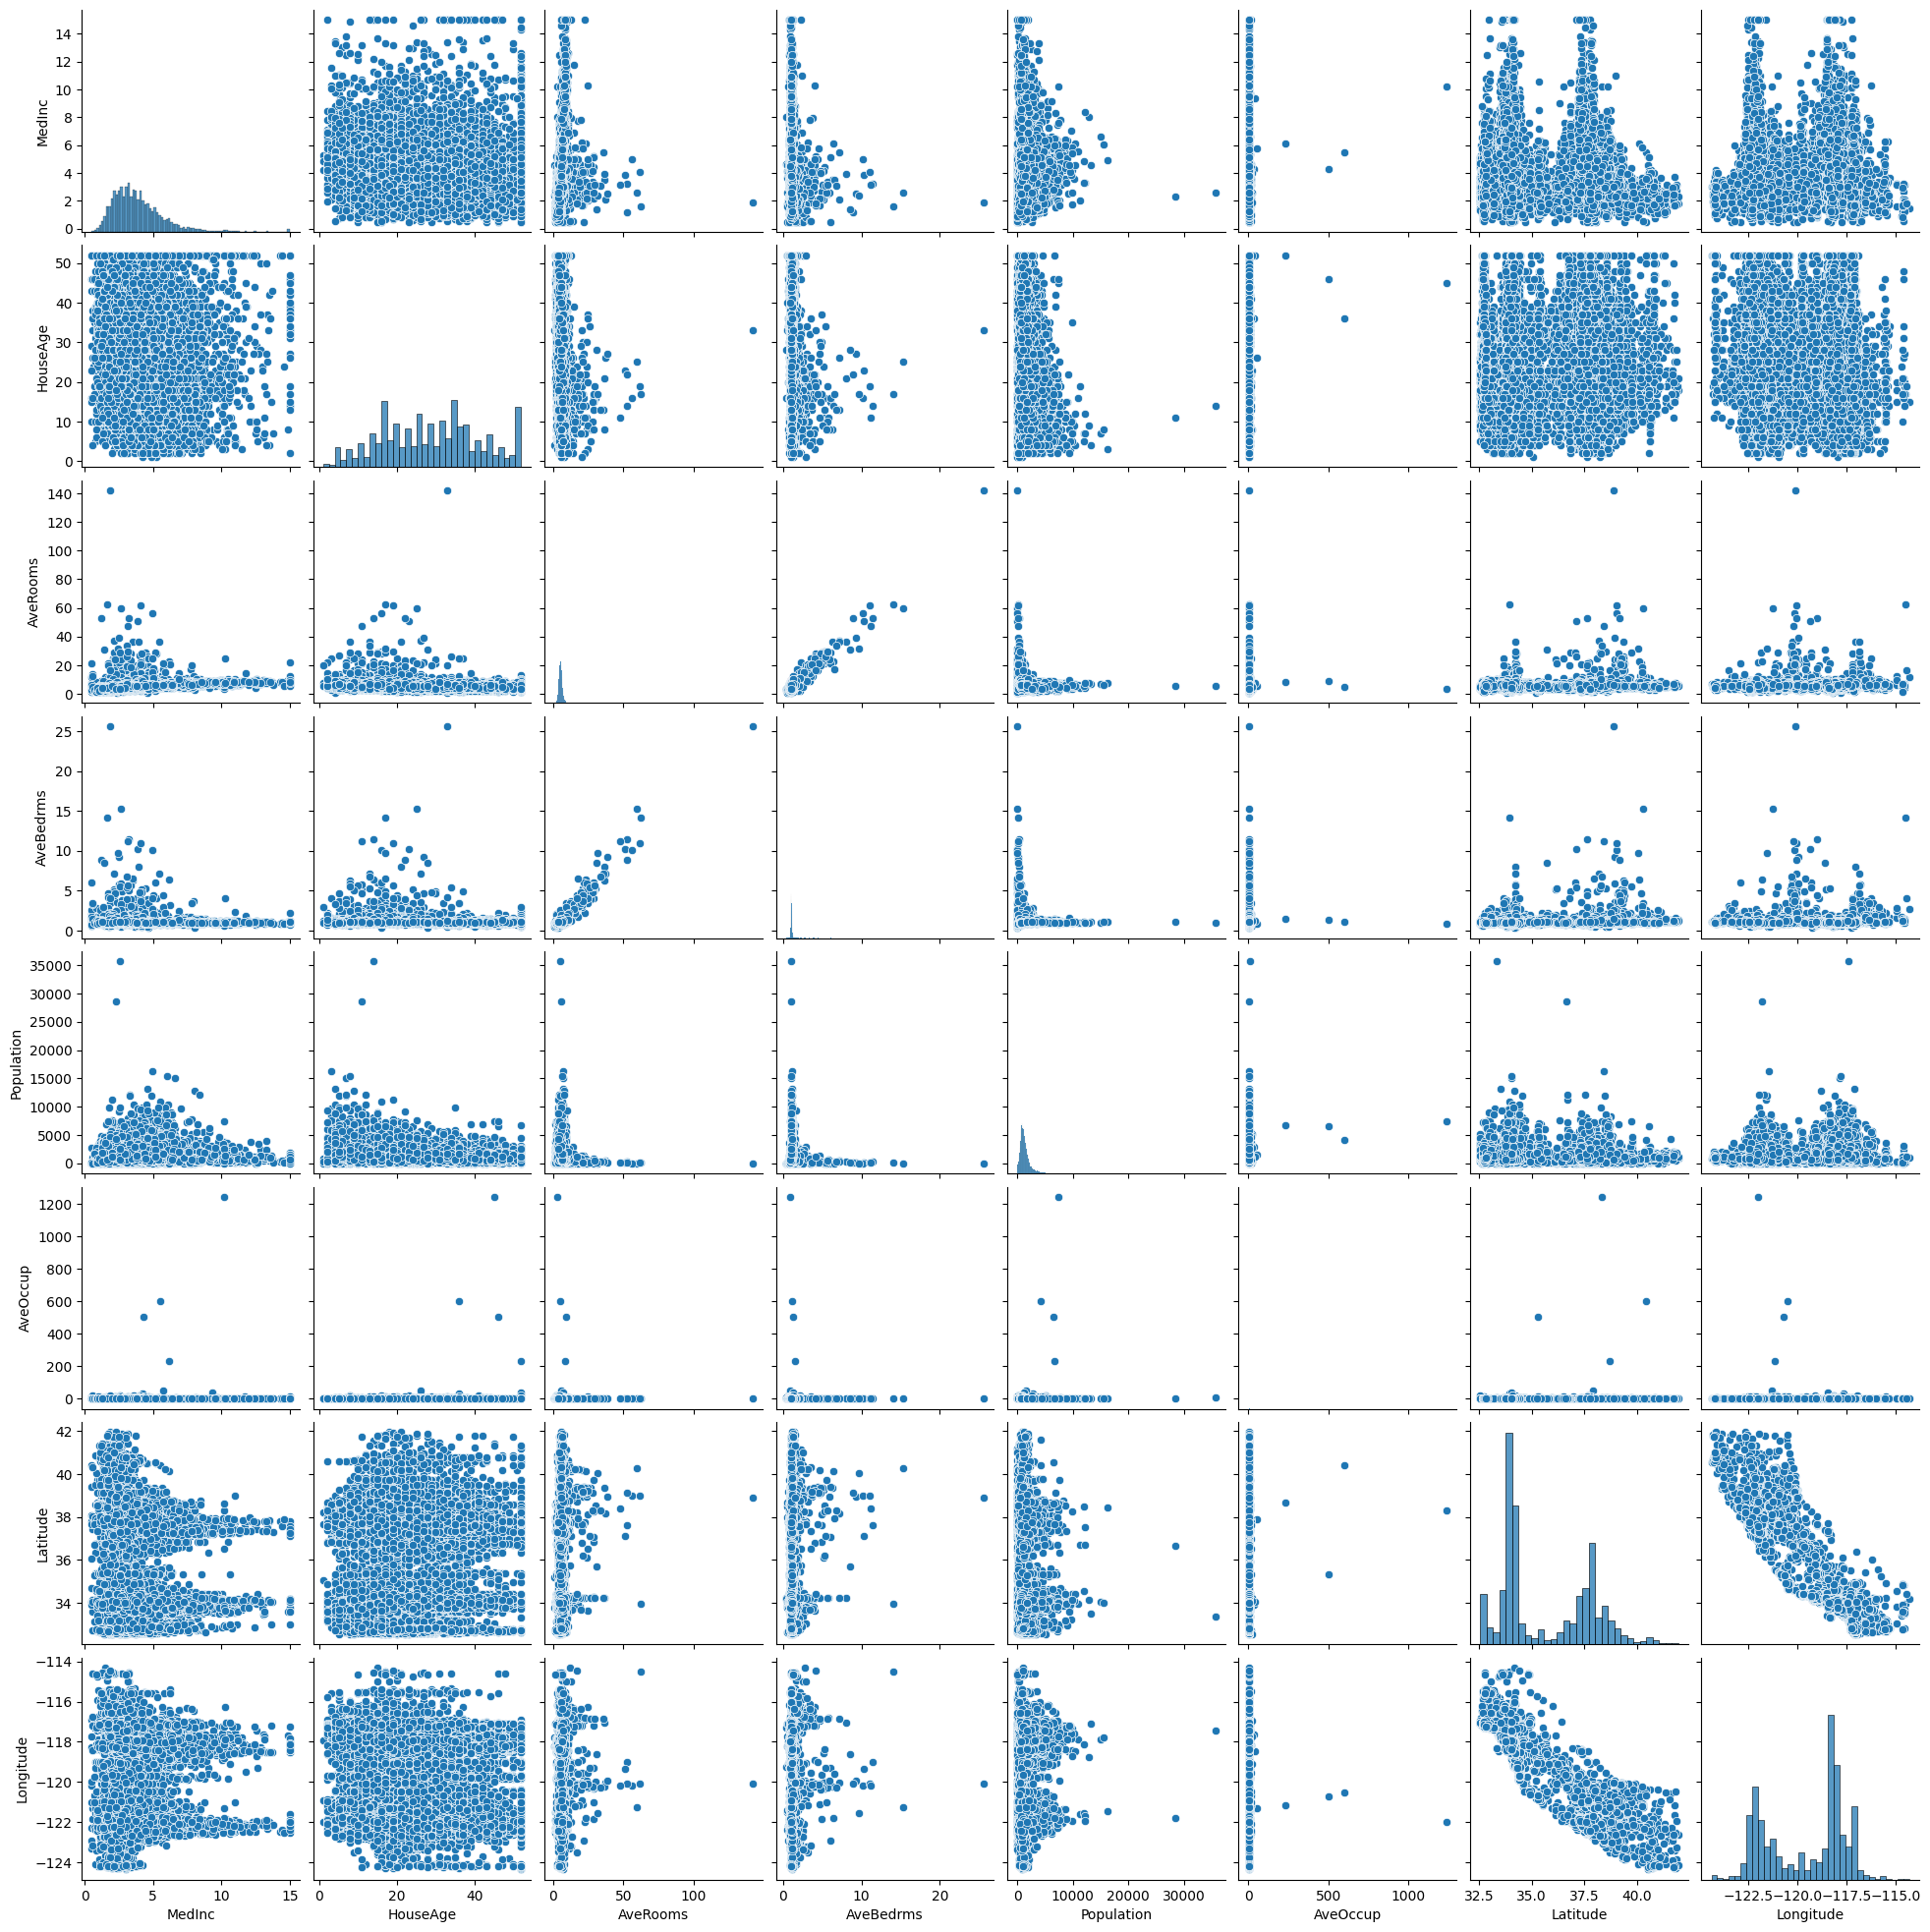

In [12]:
sns.pairplot(data= com_train_features)

## Ridge regression
The polynomial model have tendency to overfit. if we use higher order polynomial features. we will use Ridge regression which will penalizes for excessive model complexcity in the polynomial regression by adding a regulariztion term. Here we specify the regularization rate alpha as 0.5 and train the regression model. Later fe will launch hyperparameter search for the right value of alpha such that it leads cross validation error.

In [13]:
ridge_reg_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2)),
  ('feature_scaling', StandardScaler()),
  ('ridge', Ridge(alpha= 0.5))
])

ridge_reg_cv_result = cross_validate(ridge_reg_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv= cross_validation_shuffle,
                                     scoring= 'neg_mean_absolute_error',
                                     return_train_score= True,
                                     return_estimator= True)
printTestResult(ridge_reg_cv_result, 'Ridge regression')

Mean absolute error of Ridge regression model on the train set:
 0.481 +/- 0.003
Mean absolute error of linear Ridge regression on the test set:
 0.487 +/- 0.006


Hyperparameter tunning for Ridge regularization rate

In [14]:
alpha_list = np.logspace(-4, 0, num= 20)

ridge_hpt_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2)),
  ('features_scaling', StandardScaler()),
  ('ridge_reg', RidgeCV(alphas= alpha_list,
                        cv= cross_validation_shuffle,
                        scoring= 'neg_mean_absolute_error'))
])

rid_hpt_cv_result = ridge_hpt_pipeline.fit(com_train_features, com_train_labels)


In [15]:
print('The score with best aplha is:', 
      f'{rid_hpt_cv_result[-1].best_score_:.3f}')

print('Ther error with best alpha is:',
      f'{-rid_hpt_cv_result[-1].best_score_:.3f}')

The score with best aplha is: -0.473
Ther error with best alpha is: 0.473


In [16]:
print('The best value for alpha:', rid_hpt_cv_result[-1].alpha_)

The best value for alpha: 0.007847599703514606


## RidgeCV with cross validation

In [17]:
ridge_reg_hpt_cv_result = cross_validate(ridge_hpt_pipeline,
                                         com_train_features,
                                         com_train_labels,
                                         cv= cross_validation_shuffle,
                                         scoring= 'neg_mean_absolute_error', 
                                         return_train_score= True,
                                         return_estimator= True)
printTestResult(ridge_reg_hpt_cv_result, 'Ridge regression with HPT and CV')

Mean absolute error of Ridge regression with HPT and CV model on the train set:
 0.470 +/- 0.011
Mean absolute error of linear Ridge regression with HPT and CV on the test set:
 0.485 +/- 0.022


### Ridge HPT through GridSearchCV

In [18]:
ridge_grid_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2)),
  ('feature_scaling', StandardScaler()),
  ('ridge', Ridge())
])

param_grid = {'poly__degree': (1, 2, 3),
              'ridge__alpha': np.logspace(-4, 0, num= 20)}

ridge_grid_search = GridSearchCV(ridge_grid_pipeline,
                                 param_grid= param_grid,
                                 n_jobs= 2,
                                 cv= cross_validation_shuffle,
                                 scoring= 'neg_mean_absolute_error', 
                                 return_train_score= True
                                 )

ridge_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=2,
             param_grid={'poly__degree': (1, 2, 3),
                         'ridge__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [19]:
mean_train_error = -1 * ridge_grid_search.cv_results_['mean_train_score'][ridge_grid_search.best_index_]

mean_test_error = -1 * ridge_grid_search.cv_results_['mean_test_score'][ridge_grid_search.best_index_]

std_train_error = ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]
std_test_score = ridge_grid_search.cv_results_['std_test_score'][ridge_grid_search.best_index_]

print(f'Best mean absolute error of polynomial ridge regression model on the trainset is:\n',
      f'{mean_train_error:.3f} +/- {std_train_error:.3f}')

print(f'Mean absolute error of polynomial ridge regression model on the test set:\n',
      f'{mean_test_error:.3f} +/- {std_test_score:.3f}')
 

Best mean absolute error of polynomial ridge regression model on the trainset is:
 0.463 +/- 0.004
Mean absolute error of polynomial ridge regression model on the test set:
 0.474 +/- 0.015


In [20]:
print('best parameters values are:', ridge_grid_search.best_params_)

best parameters values are: {'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}


In [21]:

best_ridge_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 1)),
  ('scaling', StandardScaler()),
  ('ridge', Ridge(alpha= 0.0001))
])
best_ridge_pipeline.fit(com_train_features, com_train_labels)
mean_squared_error(com_train_labels, best_ridge_pipeline.predict(com_train_features))

# mean_squared_error(test_labels, 

0.520552216364514

In [22]:
best_ridge_pipeline.score(com_train_features, com_train_labels)

0.6098730310529241

In [23]:
secondry_best_model =  Pipeline([
  ('poly', PolynomialFeatures(degree= ridge_grid_search.best_params_['poly__degree'])),
  ('scaling', StandardScaler()),
  ('ridge', Ridge(alpha=  ridge_grid_search.best_params_['ridge__alpha']))
])
secondry_best_model.fit(com_train_features, com_train_labels)

Pipeline(steps=[('poly', PolynomialFeatures()), ('scaling', StandardScaler()),
                ('ridge', Ridge(alpha=0.007847599703514606))])

In [24]:
secondry_best_model.score(com_train_features, com_train_labels)

0.6824495257528855

## Lasso Regression

In [25]:
lass_regression_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2)),
  ('feature_scaling', StandardScaler()),
  ('lasso', Lasso(alpha= 0.01))
])

lasso_reg_cv_result = cross_validate(lass_regression_pipeline, 
                                     com_train_features,
                                     com_train_labels, 
                                     cv= cross_validation_shuffle,
                                     scoring= 'neg_mean_absolute_error',
                                     return_train_score= True,
                                     return_estimator= True)
printTestResult(lasso_reg_cv_result, 'Lasso Cross validation')

/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+01, tolerance: 1.654e+00
  model = cd_fast.enet_coordinate_descent(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+01, tolerance: 1.669e+00
  model = cd_fast.enet_coordinate_descent(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

Mean absolute error of Lasso Cross validation model on the train set:
 0.529 +/- 0.003
Mean absolute error of linear Lasso Cross validation on the test set:
 0.528 +/- 0.008


/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+01, tolerance: 1.658e+00
  model = cd_fast.enet_coordinate_descent(


### With Grid search CV

In [26]:
param_grid = [
  {'poly__degree': (1, 2, 3),
  'lasso__alpha': np.logspace(-4, 0, 20)}
]
lass_regression_pipeline = Pipeline([
  ('poly', PolynomialFeatures()),
  ('feature_scaling', StandardScaler()),
  ('lasso', Lasso())
])

lasso_rig_grid_search = GridSearchCV(lass_regression_pipeline,
                                     param_grid= param_grid,
                                     n_jobs= 2,
                                     cv= cross_validation_shuffle,
                                     scoring= 'neg_mean_absolute_error', 
                                     return_train_score= True)
lasso_rig_grid_search.fit(com_train_features, com_train_labels)

/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e+03, tolerance: 1.654e+00
  model = cd_fast.enet_coordinate_descent(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.553e+03, tolerance: 1.658e+00
  model = cd_fast.enet_coordinate_descent(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=2,
             param_grid=[{'lasso__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                          'poly__degree': (1, 2, 3)}],
             return_train_score=True, scoring='neg_mean_absolute_error')

In [27]:
mean_train_error = -1 * lasso_rig_grid_search.cv_results_['mean_train_score'][lasso_rig_grid_search.best_index_]

mean_test_error = -1 * lasso_rig_grid_search.cv_results_['mean_test_score'][lasso_rig_grid_search.best_index_]

std_train_error = lasso_rig_grid_search.cv_results_['std_train_score'][lasso_rig_grid_search.best_index_]
std_test_score = lasso_rig_grid_search.cv_results_['std_test_score'][lasso_rig_grid_search.best_index_]

print(f'Best mean absolute error of polynomial lasso regression model on the trainset is:\n',
      f'{mean_train_error:.3f} +/- {std_train_error:.3f}')

print(f'Mean absolute error of polynomial lasso regression model on the test set:\n',
      f'{mean_test_error:.3f} +/- {std_test_score:.3f}')

Best mean absolute error of polynomial lasso regression model on the trainset is:
 0.462 +/- 0.003
Mean absolute error of polynomial lasso regression model on the test set:
 0.488 +/- 0.046


In [28]:
print('best parameters ', lasso_rig_grid_search.best_params_)

best parameters  {'lasso__alpha': 0.0001, 'poly__degree': 3}


SGD: Regularization and HPT

In [31]:
poly_sgd_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2)),
  ('feature_scaling', StandardScaler()),
  ('sgd_reg', SGDRegressor(
    penalty= 'elasticnet',
    random_state= 42
  ))
])

poly_sgd_cv_results = cross_validate(poly_sgd_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv= cross_validation_shuffle,
                                     scoring= 'neg_mean_absolute_error',
                                     return_train_score= True,
                                     return_estimator= True)

printTestResult(poly_sgd_cv_results, "Polynomial sgd regression")

Mean absolute error of Polynomial sgd regression model on the train set:
 10824283052.546 +/- 4423288211.832
Mean absolute error of linear Polynomial sgd regression on the test set:
 10946788540.250 +/- 5396536227.703


#### Let's search for the best set of parameters for polynomial + SGD pipeline with RandomizedSearchCV

In [33]:
param_distribution = {
  'poly__degree': [1, 2, 3],
  'sgd_reg__learning_rate': ['constant', 'adaptive', 'invscaling'],
  'sgd_reg__l1_ratio': uniform(0, 1),
  'sgd_reg__eta0': loguniform(1e-5, 1),
  'sgd_reg__power_t': uniform(0, 1)
}

poly_sgd_random_search = RandomizedSearchCV(
  poly_sgd_pipeline, param_distribution,
  n_iter=10, cv= cross_validation_shuffle, scoring= 'neg_mean_absolute_error'
)
poly_sgd_random_search.fit(com_train_features, com_train_labels)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('feature_scaling',
                                              StandardScaler()),
                                             ('sgd_reg',
                                              SGDRegressor(penalty='elasticnet',
                                                           random_state=42))]),
                   param_distributions={'poly__degree': [1, 2, 3],
                                        'sgd_reg__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe2d8755510>,
                                        'sgd_reg__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe2ed08f6d0>,
                                        'sgd_reg__learning_rate': ['constant',
                                                                   'adaptive',
                                                                   'invscaling'],
                                        'sgd_reg__power_t': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe2d8756410>},
                   scoring='neg_mean_absolute_error')

In [34]:
poly_sgd_random_search.best_score_

-0.5289162890588932

In [35]:
poly_sgd_random_search.best_params_

{'poly__degree': 2,
 'sgd_reg__eta0': 2.9995118529892624e-05,
 'sgd_reg__l1_ratio': 0.37081825219826636,
 'sgd_reg__learning_rate': 'adaptive',
 'sgd_reg__power_t': 0.32518332202674705}

### Comparison of weight vectors

In [38]:
feature_name = poly_reg_cv_result['estimator'][0][0].get_feature_names_out(
  input_features=train_features.columns
)
feature_name

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

In [39]:
coefs = [est[-1].coef_ for est in poly_reg_cv_result['estimator']]
weights_polynomial_regression = pd.DataFrame(coefs, columns= feature_name)

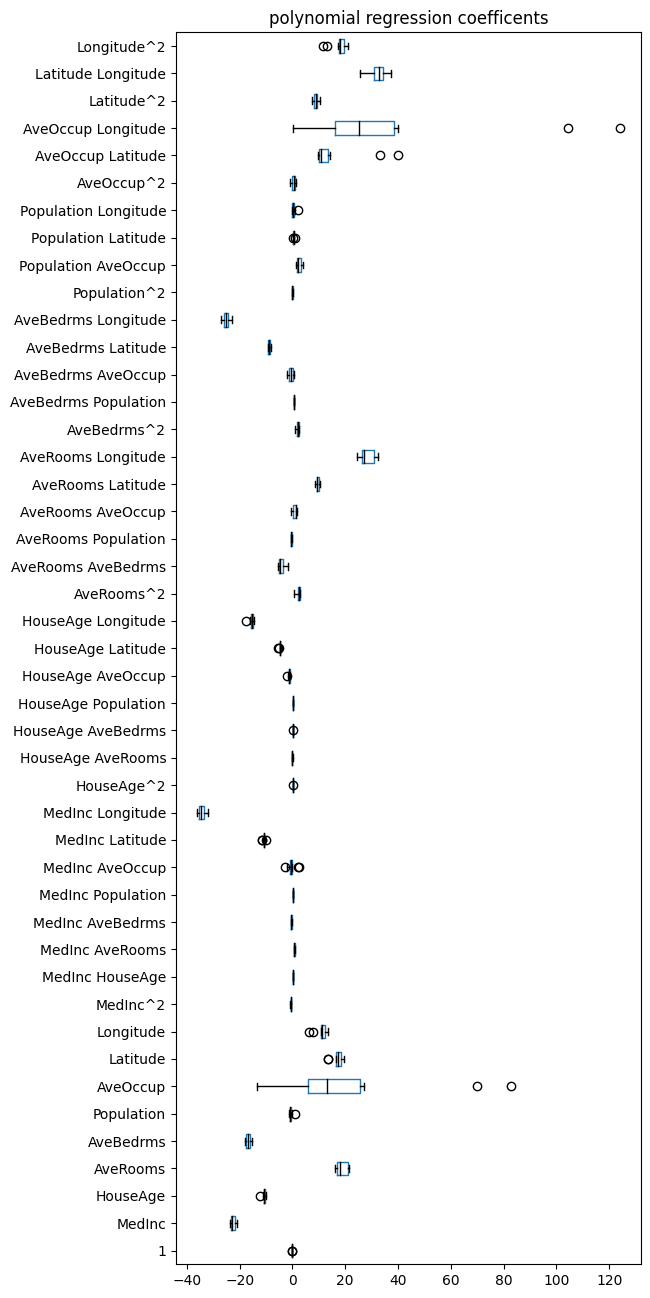

In [42]:
color = {'whiskers':'black', 'medians': 'black', 'caps': 'black'}
weights_polynomial_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title('polynomial regression coefficents')

In [45]:
features_names = ridge_reg_cv_result['estimator'][0][0].get_feature_names_out(
  input_features= train_features.columns
)
features_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

In [46]:
coefs = [est[-1].coef_ for est in ridge_reg_cv_result['estimator']]
weights_polynomial_regression = pd.DataFrame(coefs, columns= features_names)

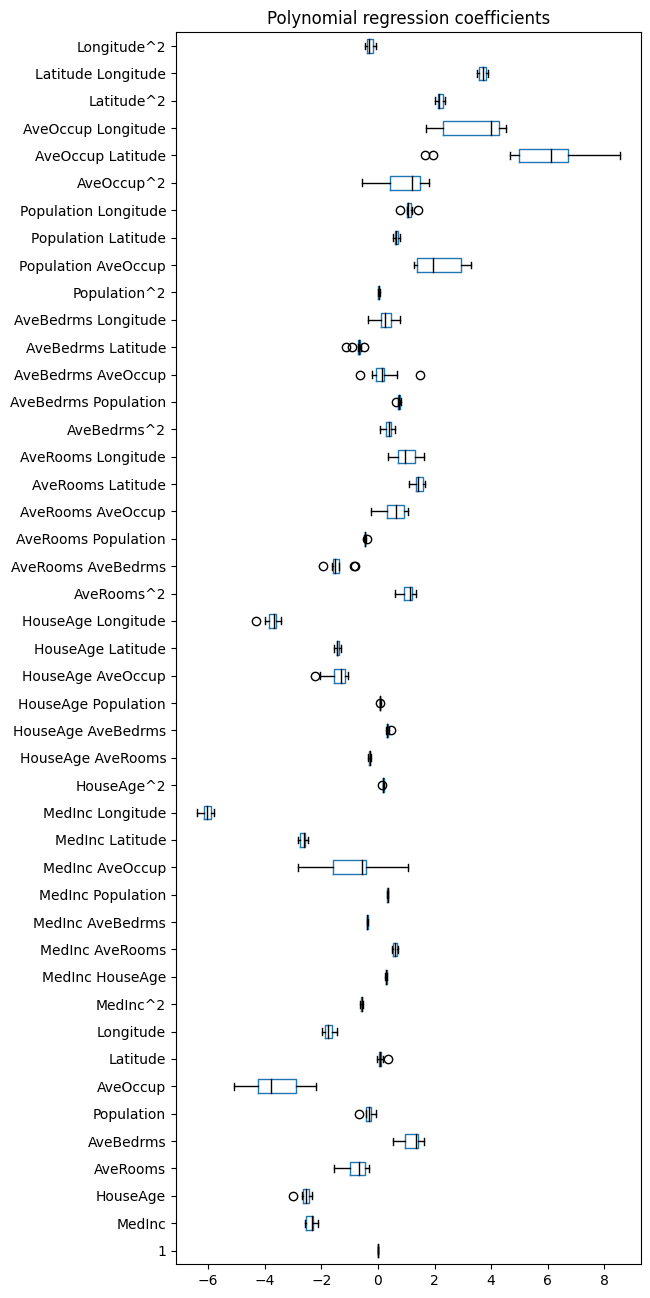

In [47]:
weights_polynomial_regression.plot.box(color= color, vert=False, figsize=(6, 16))
_ = plt.title('Polynomial regression coefficients')

### performance on the test set

#### Baseline

In [48]:
baseline_model_median = DummyRegressor(strategy= 'median')
baseline_model_median.fit(train_features, train_labels)
mean_absolute_percentage_error(test_labels, baseline_model_median.predict(test_features))


0.5348927548151625

In [49]:
mean_absolute_percentage_error(test_labels, lin_reg_cv_results['estimator'][0].predict(test_features))

0.32120472175482895

In [53]:
mean_absolute_percentage_error(test_labels, poly_sgd_random_search.best_estimator_.predict(test_features))

0.31392613568440414

In [54]:

mean_absolute_percentage_error(test_labels, ridge_grid_search.best_estimator_.predict(test_features))

0.2711033645148187

In [55]:
mean_absolute_percentage_error(test_labels, lasso_rig_grid_search.best_estimator_.predict(test_features))

0.2807496926381011